In [ ]:
from sklearn.decomposition import PCA
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import ADASYN
# from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SKPipeline

from sklearn.svm import SVC
from itertools import combinations

from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import mode


In [2]:
stroke = pd.read_csv("../00-data/healthcare-dataset-stroke-data.csv")

stroke


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Splitto variabili indipendenti ed output

In [3]:
X = stroke.drop(['stroke', 'id'], axis=1)

y = stroke['stroke'].values

creo una funzione per fare oneHotEncoding e imputazione

In [4]:
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

numerical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='mean')),
  ('scaler', StandardScaler())
])

categorical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_with_imputation = ColumnTransformer(
  transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
  ])


pipeline = SKPipeline([
  ('preprocessor', preprocessor_with_imputation),
#   ('undersampler', RandomUnderSampler(random_state=0, sampling_strategy=0.15)),
#   ('oversampler', ADASYN(n_neighbors=7, random_state=0, sampling_strategy=1.0)),
  ('pca', PCA(random_state=0)),
  
  # ('svm', SVC(random_state=42, C=1.0, kernel='rbf')),
  # ('secondary_scaler', StandardScaler())
])

calcolo train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

pipeline.fit_transform(X_train)

In [6]:
X_train_pca = pipeline.fit_transform(X_train)

X_test_pca = pipeline.transform(X_test)

In [7]:
X_train_pca

array([[ 1.06666096e-01, -4.94584625e-01, -3.03622103e-01, ...,
        -3.33066907e-16, -1.11022302e-16, -8.88178420e-16],
       [ 1.34957705e+00, -4.10214111e-01,  3.71820684e-02, ...,
        -1.55431223e-15, -5.55111512e-16, -8.88178420e-16],
       [-2.80502455e+00,  7.56789982e-01,  2.82649671e-01, ...,
         3.33066907e-16, -5.55111512e-17,  7.77156117e-16],
       ...,
       [-5.87458043e-02, -3.00080623e-01, -3.09942030e-01, ...,
        -3.33066907e-16, -1.11022302e-16, -8.88178420e-16],
       [-7.70373960e-01,  1.56001729e-01,  4.70622655e-01, ...,
        -5.55111512e-16,  4.44089210e-16,  0.00000000e+00],
       [ 1.48316640e+00, -7.85745419e-01,  1.24444897e+00, ...,
         2.99760217e-15,  1.33226763e-15,  3.10862447e-15]],
      shape=(3577, 21))

esploro il dataset con la PCA per vedere se riesco a trovare una coppia che può essere clusterizzata in modo accettabile

In [8]:
def explorationByPCA (X, y, pipeline, n_components):
  pipeline.named_steps['pca'].n_components = n_components
  X_pca = pipeline.fit_transform(X)

  for i in range(n_components - 1):
    for j in range(i + 1, n_components):
      plt.figure(figsize=(12, 8))
      plt.scatter(X_pca[:, i], X_pca[:, j], c=y, cmap='viridis', s=20, alpha=0.7)
      plt.xlabel(f'PCA Component {i+1}')
      plt.ylabel(f'PCA Component {j+1}')
      plt.title(f'Scatterplot PCA Component {i+1} vs {j+1}')
      plt.colorbar(label='Classe')
      plt.show()

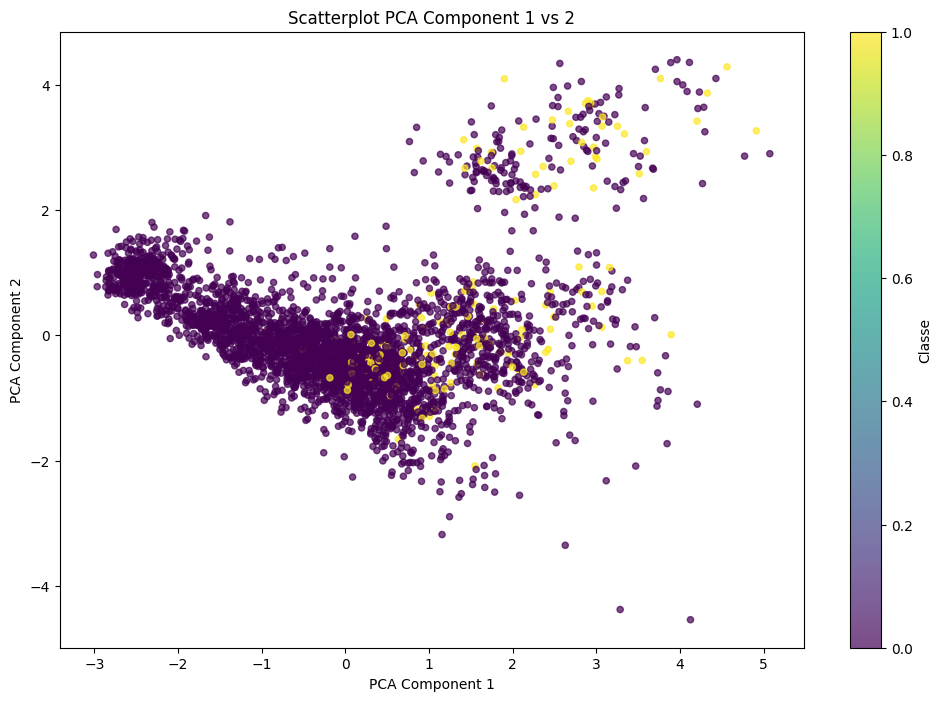

In [9]:
explorationByPCA(X_train, y_train, pipeline, 2)

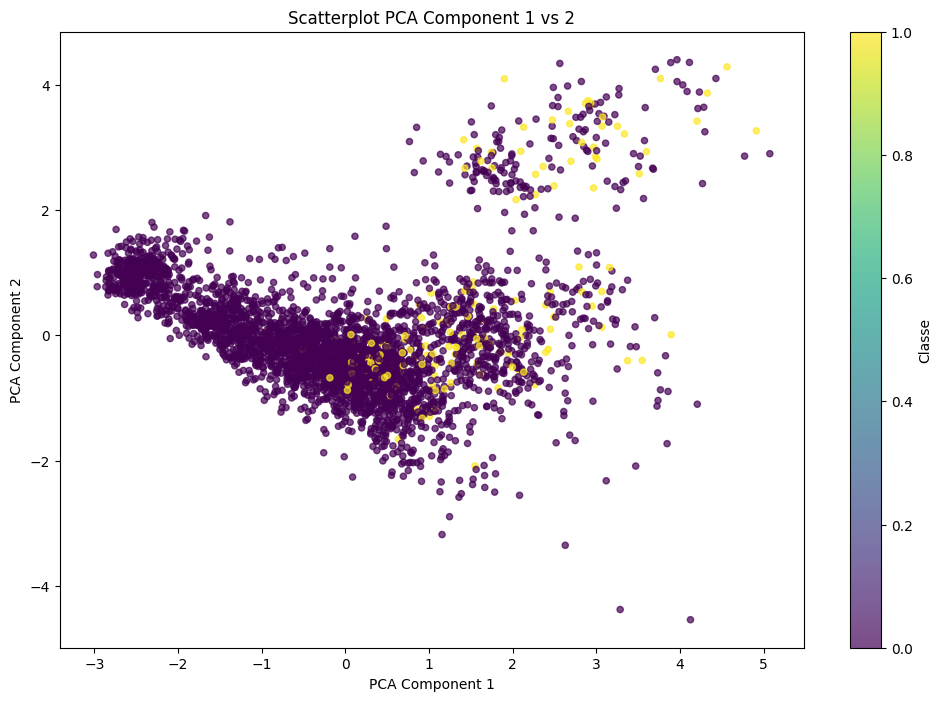

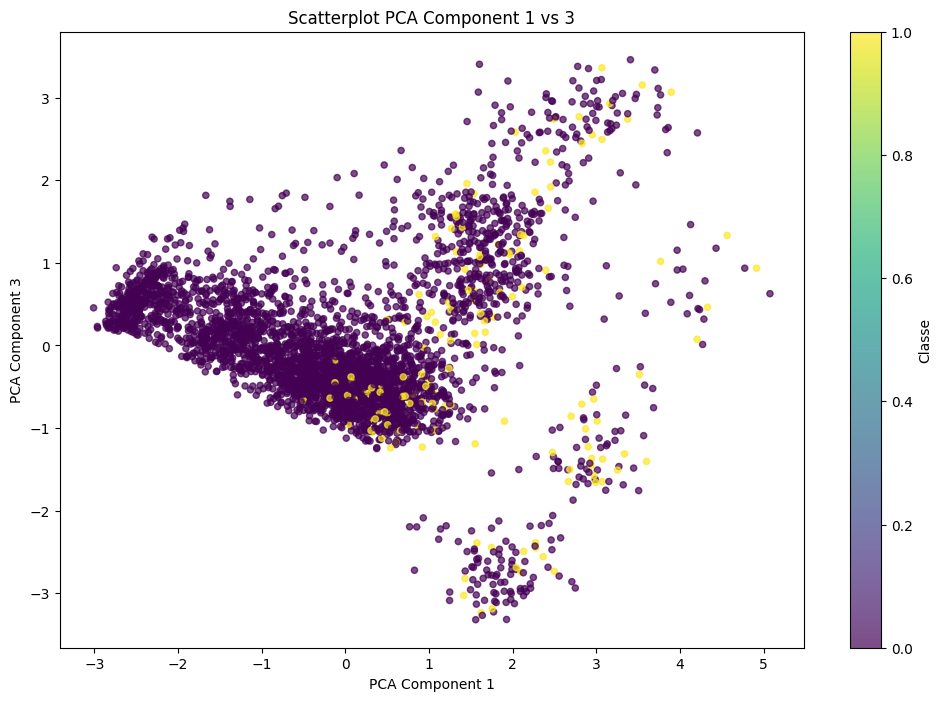

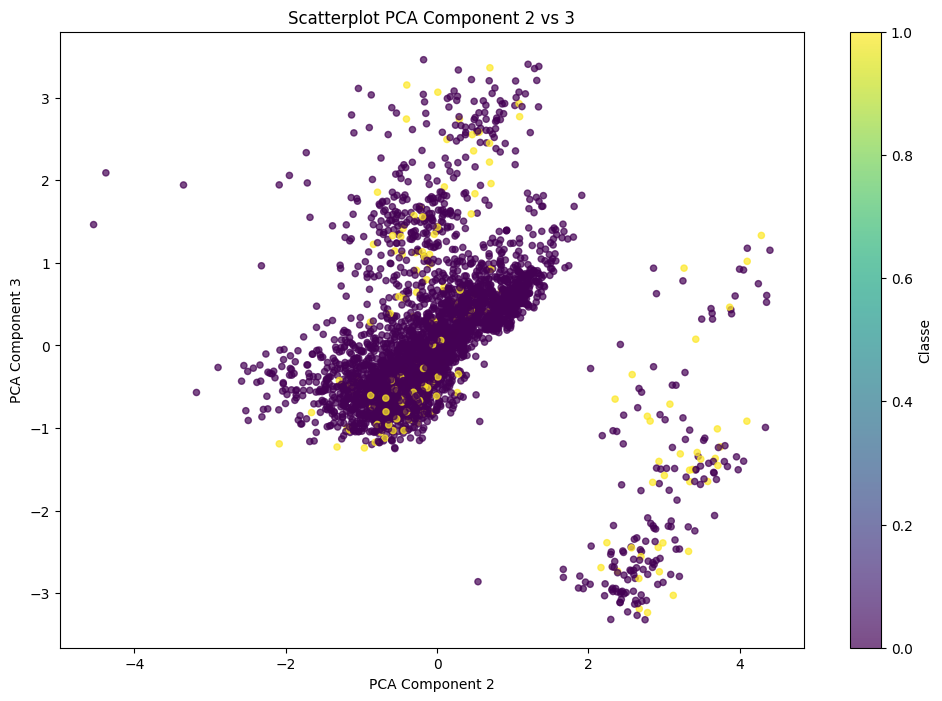

In [10]:
explorationByPCA(X_train, y_train, pipeline, 3)

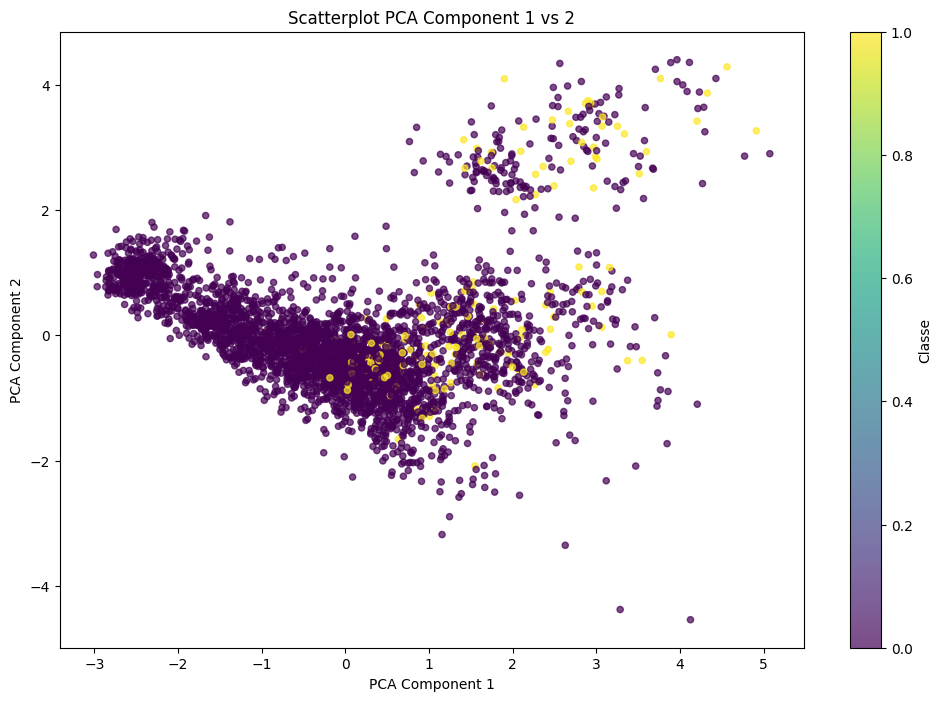

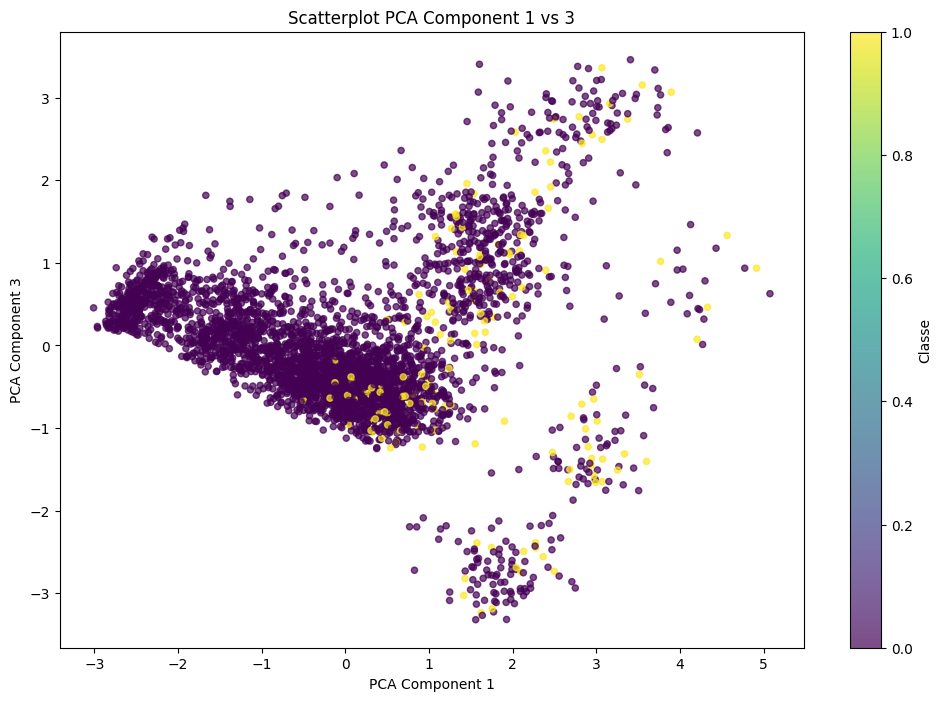

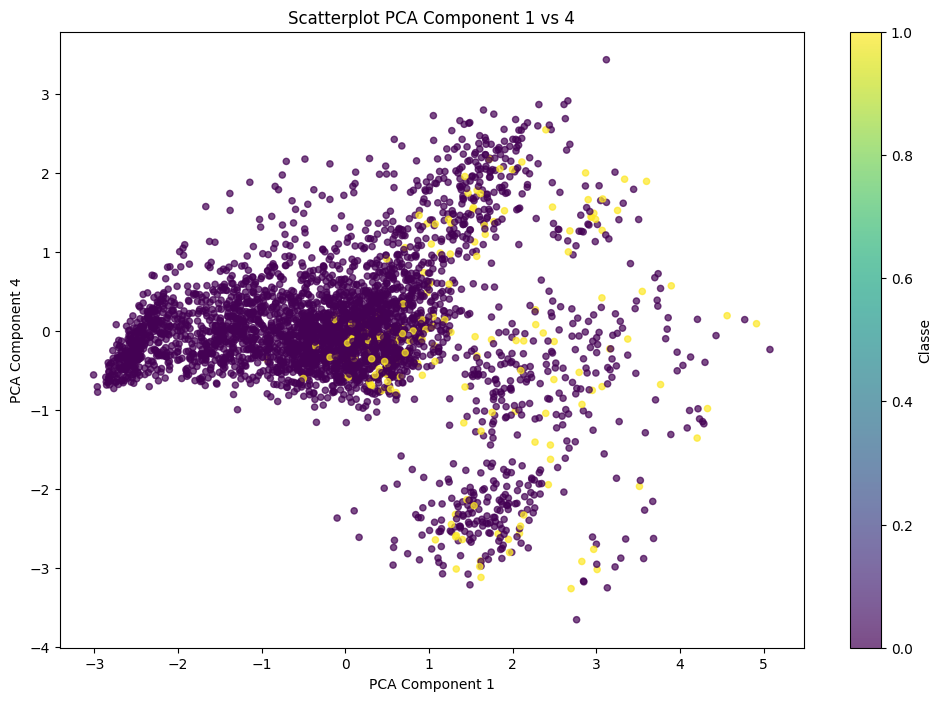

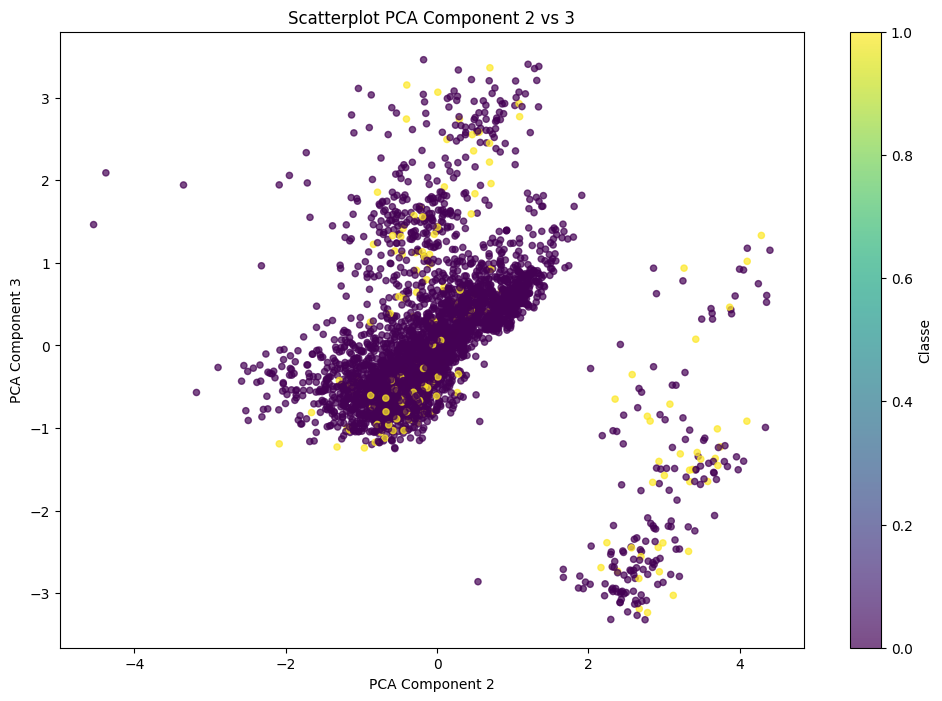

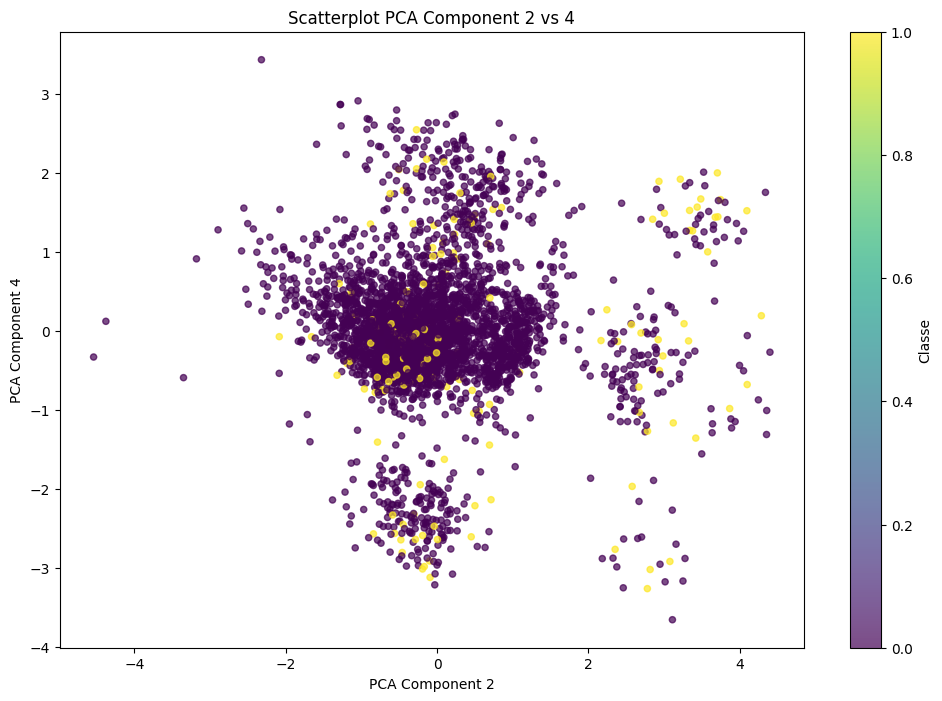

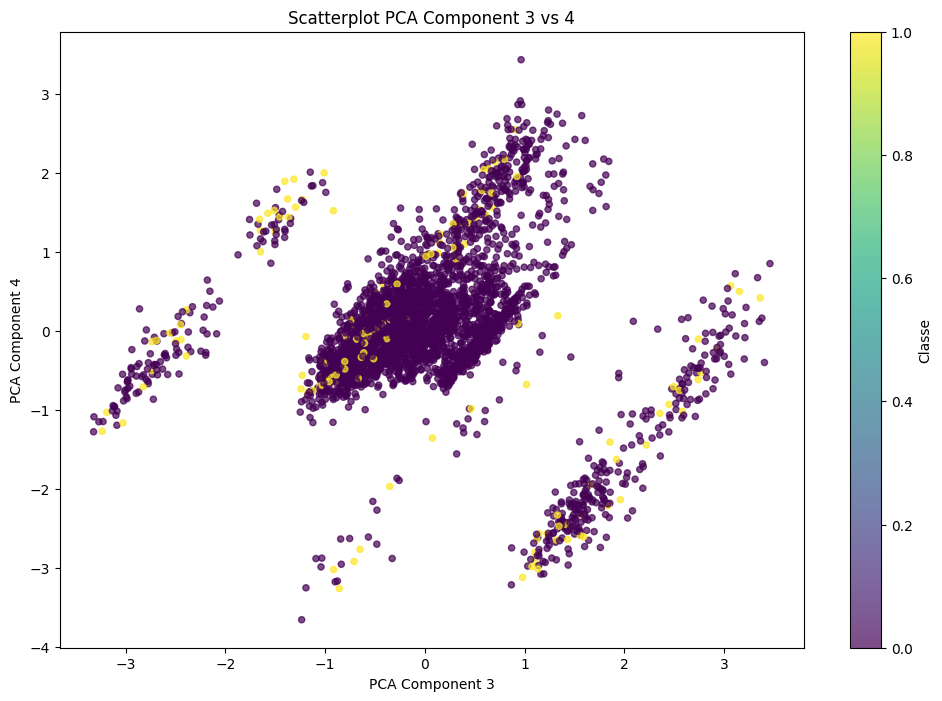

In [11]:
explorationByPCA(X_train, y_train, pipeline, 4)

In [12]:
# questi esempi sono stati comunque testati ma li ho commentati in quanto occupavano molto spazio e non tornavano alcun risultato utile
# explorationByPCA(X_train, y_train, pipeline, 5)
# explorationByPCA(X_train, y_train, pipeline, 6)
# explorationByPCA(X_train, y_train, pipeline, 7)
# explorationByPCA(X_train, y_train, pipeline, 8)
# explorationByPCA(X_train, y_train, pipeline, 9)
# explorationByPCA(X_train, y_train, pipeline, 10)

Non sembra esistere un modo per separare le classi basandosi su visualizzazione in 2 dimensioni.

Potrei provare a fare pca a più dimensioni e vedere se riesco a trovare un algoritmo che cerca di separarli automaticamente

In [13]:
def calculate_svm_performance(X_pca_subset, y_labels, scoring='roc_auc'):
    # Utilizziamo SVC lineare per trovare un iperpiano
    model = SVC(kernel='linear', random_state=0, probability=False, class_weight='balanced') # probability=False per non calcolare probabilità se non serve
    # Cross-validazione per una stima più robusta
    # Attenzione al bilanciamento del dataset: per roc_auc è ok, per f1 potresti voler usare f1_weighted o f1_macro
    # Oppure applicare bilanciamento prima della CV (es. con SMOTE nella pipeline principale)
    scores = cross_val_score(model, X_pca_subset, y_labels, cv=5, scoring=scoring)
    return np.mean(scores)

def findDataByPCA(X, y, pipeline, n_components, n_dims_to_combine=2):
    """
    Esplora le combinazioni di componenti PCA per trovare la migliore separazione tra le classi.

    Args:
        X (np.array or pd.DataFrame): Le feature del dataset.
        y (np.array or pd.Series): Le etichette di classe (0 o 1).
        pipeline (sklearn.pipeline.Pipeline): La pipeline che include lo step 'pca'.
        n_components (int): Il numero massimo di componenti PCA da estrarre.
        n_dims_to_combine (int): Il numero di dimensioni per ogni combinazione
                                 da testare (es. 2 per coppie, 3 per terne).

    Returns:
        tuple: (best_metric_value, best_components_indices, best_X_pca_projection)
               - best_metric_value (float): Il valore della metrica di separazione più alto.
               - best_components_indices (tuple): Gli indici delle componenti PCA per la migliore separazione.
               - best_X_pca_projection (np.array): La proiezione PCA corrispondente alla migliore separazione.
    """
    if not 'pca' in pipeline.named_steps:
        raise ValueError("La pipeline deve contenere uno step chiamato 'pca'.")
    if n_dims_to_combine > n_components:
        raise ValueError("n_dims_to_combine non può essere maggiore di n_components.")
    if n_dims_to_combine <= 0:
        raise ValueError("n_dims_to_combine deve essere un numero positivo.")

    # Imposta il numero di componenti da estrarre nella PCA
    pipeline.named_steps['pca'].n_components = n_components
    X_pca_full = pipeline.fit_transform(X)

    best_metric_value = -np.inf # Inizializza con un valore molto basso
    best_components_indices = None
    best_X_pca_projection = None

    # Genera tutte le combinazioni possibili di 'n_dims_to_combine' componenti
    all_combinations = list(combinations(range(n_components), n_dims_to_combine))

    for combo_indices in all_combinations:
        # Estrai le componenti PCA per la combinazione corrente
        X_pca_subset = X_pca_full[:, list(combo_indices)]

        # Calcola la metrica di separazione
        current_metric = calculate_svm_performance(X_pca_subset, y)

        if current_metric > best_metric_value:
            best_metric_value = current_metric
            best_components_indices = combo_indices
            best_X_pca_projection = X_pca_subset

    return best_metric_value, best_components_indices, best_X_pca_projection

In [14]:
res = []
n_components = 9
for i in range(5, n_components - 1):
  for j in range(i + 1, n_components):
    best_metric_value, best_component_indices, best_x_pca_projection = findDataByPCA(X_train, y_train, pipeline, j, i)
    res.append({'i': i, 'j': j, 'n_principal_components': j, 'best_metric_value': best_metric_value, 'best_component_indices': best_component_indices})

In [15]:
dfRes = pd.DataFrame(res)
dfRes = dfRes.drop(['i', 'j'], axis=1)
dfRes.drop_duplicates()
sorted_data = sorted(res, key=lambda x: x['best_metric_value'], reverse=True)
sorted_data

[{'i': 5,
  'j': 6,
  'n_principal_components': 6,
  'best_metric_value': np.float64(0.8377205666407532),
  'best_component_indices': (0, 2, 3, 4, 5)},
 {'i': 5,
  'j': 7,
  'n_principal_components': 7,
  'best_metric_value': np.float64(0.8377205666407532),
  'best_component_indices': (0, 2, 3, 4, 5)},
 {'i': 5,
  'j': 8,
  'n_principal_components': 8,
  'best_metric_value': np.float64(0.8377205666407532),
  'best_component_indices': (0, 2, 3, 4, 5)},
 {'i': 6,
  'j': 7,
  'n_principal_components': 7,
  'best_metric_value': np.float64(0.8363187477634225),
  'best_component_indices': (0, 1, 2, 3, 4, 5)},
 {'i': 6,
  'j': 8,
  'n_principal_components': 8,
  'best_metric_value': np.float64(0.8363187477634225),
  'best_component_indices': (0, 1, 2, 3, 4, 5)},
 {'i': 7,
  'j': 8,
  'n_principal_components': 8,
  'best_metric_value': np.float64(0.8354006836214662),
  'best_component_indices': (0, 1, 2, 3, 4, 5, 6)}]

In [16]:
def evaluate_pca_with_classifier(X, y, pipeline, n_components, dimension_list):
    pipeline.named_steps['pca'].n_components = n_components
    X_pca = pipeline.transform(X)

    X_selected = X_pca[:, dimension_list]

    classifier = SVC(kernel='rbf', random_state=0, class_weight='balanced') # Puoi provare anche 'linear' o RandomForestClassifier

    y_pred = cross_val_predict(classifier, X_selected, np.array(y), cv=5)

    cm = confusion_matrix(np.array(y), y_pred)
    class_names = ['Classe 0 (Nessun ictus)', 'Classe 1 (Ictus)']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d')
    plt.show()
    perc_true_negative = cm[0,0]*100/(cm[0,0]+cm[0,1])
    perc_true_positive = cm[1,1]*100/(cm[1,0]+cm[1,1])
    print(f"Percentuale di veri negativi: {perc_true_negative:.2f}%")
    print(f"Percentuale di veri positivi: {perc_true_positive:.2f}%")
    print(f"Percentuale di falsi negativi: {100 - perc_true_negative:.2f}%")
    print(f"Percentuale di falsi positivi: {100 - perc_true_positive:.2f}%")
    return cm

valutazione dati di train


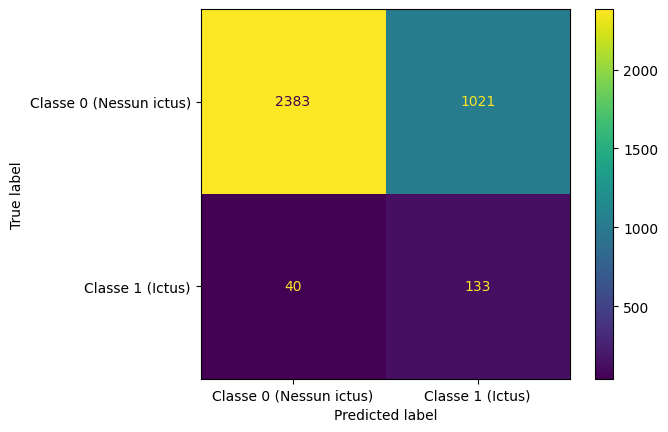

Percentuale di veri negativi: 70.01%
Percentuale di veri positivi: 76.88%
Percentuale di falsi negativi: 29.99%
Percentuale di falsi positivi: 23.12%


In [19]:
print('valutazione dati di train')
cm = evaluate_pca_with_classifier(X_train, y_train, pipeline, n_components=6, dimension_list=[0,2,3,4,5])


valutazione dati di test


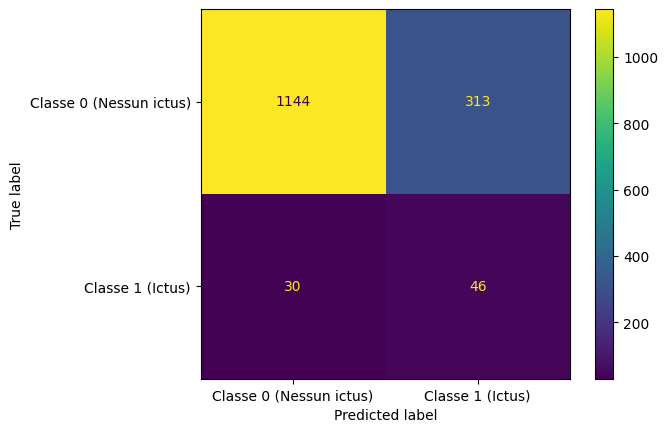

Percentuale di veri negativi: 78.52%
Percentuale di veri positivi: 60.53%
Percentuale di falsi negativi: 21.48%
Percentuale di falsi positivi: 39.47%


In [20]:
print('valutazione dati di test')
cm = evaluate_pca_with_classifier(X_test, y_test, pipeline, n_components=6, dimension_list=[0,2,3,4,5])
